In [23]:
import matplotlib.pyplot as plt
import numpy as np
import chess_stats as cs

In [26]:
df = cs.game_stats_df('bubbasparx666')

In [11]:
import chess
import chess.uci
import chess.pgn
from io import StringIO

def move_evaluation(pgn_string, engine_path, evaluation_time=5000, output='list'):
    '''Takes pgn and returns engine evaluation
    Params:
        pgn_string: A string of the pgn
        engine_path: A string of the path to your engine
        evaluation_time: How long the engine will spend evaluating each move (in ms), default is 5000 ms (5 seconds)
        output: either 'list' (list of evaluation values) or 'graph' (graph of evaluation values)
    Returns: 
        If output == list: A list of numbers corresponding to the engine evaluation at each move of the game, positive favors white and negitive favors black
        If output == graph'''
        
    pgn = StringIO(pgn_string)
    game = chess.pgn.read_game(pgn)

    board = game.board()

    centipawn_eval = []
    #Loop over all game nodes:
    while not game.is_end():
        node = game.variations[0]
        board = game.board() 
        game = node

        #load your engine:
        handler = chess.uci.InfoHandler()
        engine = chess.uci.popen_engine(engine_path) 
        engine.info_handlers.append(handler)

        #give position to the engine:
        engine.position(board)

        #Set your evaluation time, in ms:
        evaluation = engine.go(movetime=evaluation_time)

        if handler.info["score"][1][0]:
            centipawn_eval.append(handler.info["score"][1][0])
        else:
            mate_in = handler.info["score"][1][1]*8000
            centipawn_eval.append(mate_in)
    eval_list = [eval_ * -1 if idx % 2 != 0 else eval_ for idx, eval_ in enumerate(centipawn_eval)] 
    
    if output == 'list':
        return eval_list
    elif output == 'graph':
        fig, ax = plt.subplots(figsize=(15, 7))
        x = list(range(len(eval_list)))
        y = eval_list
        ax.plot(x, y)
        

In [ ]:
engine_path = '/Users/bmcgarry/projects/Stockfish/src/stockfish'

In [28]:
df.end_time[320]

Timestamp('2015-10-30 20:50:46')

In [12]:
[eval_ * -1 if idx % 2 != 0 else eval_ for idx, eval_ in enumerate(centipawn_eval)]

[114,
 20,
 77,
 -16,
 96,
 28,
 102,
 68,
 68,
 -29,
 112,
 -22,
 58,
 -32,
 -15,
 -90,
 -10,
 -32,
 133,
 99,
 152,
 107,
 1569,
 1075,
 1097,
 139,
 579,
 117,
 188,
 84,
 117,
 39,
 95,
 -87,
 -152,
 -215,
 -312,
 -794,
 -635,
 -665,
 -592,
 -751,
 -693,
 -742,
 -589,
 -760,
 -733,
 -861,
 -774,
 -1374,
 -877,
 -1403,
 -1388,
 -1467,
 -1443,
 -1802,
 -1407,
 -1476,
 -1439,
 -1494,
 -1473,
 -1500,
 -1444,
 -1508,
 -1437,
 -1491,
 -1475,
 -1519,
 -1480,
 -1587,
 -1555,
 -5862]

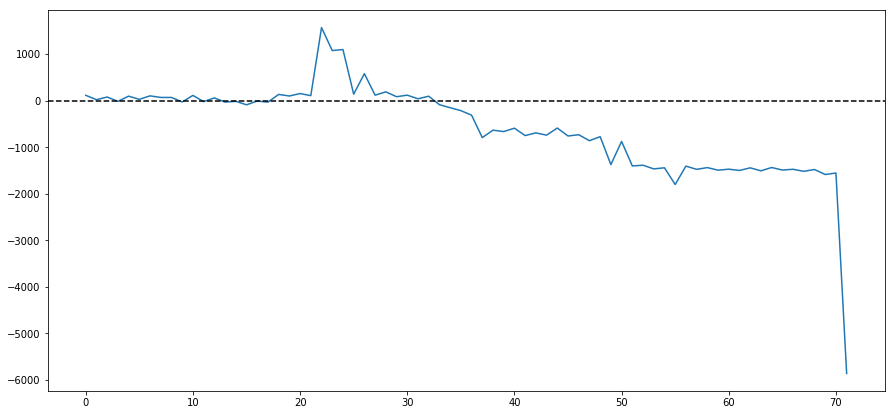

In [13]:
fig, ax = plt.subplots(figsize=(15, 7))

# y = centipawn_eval_5[:28]
x = list(range(len(centipawn_eval)))
# ax.plot(x, y)

y_5 = [eval_ * -1 if idx % 2 != 0 else eval_ for idx, eval_ in enumerate(centipawn_eval)]
ax.plot(x, y_5)
ax.axhline(0, ls='dashed', color='black')

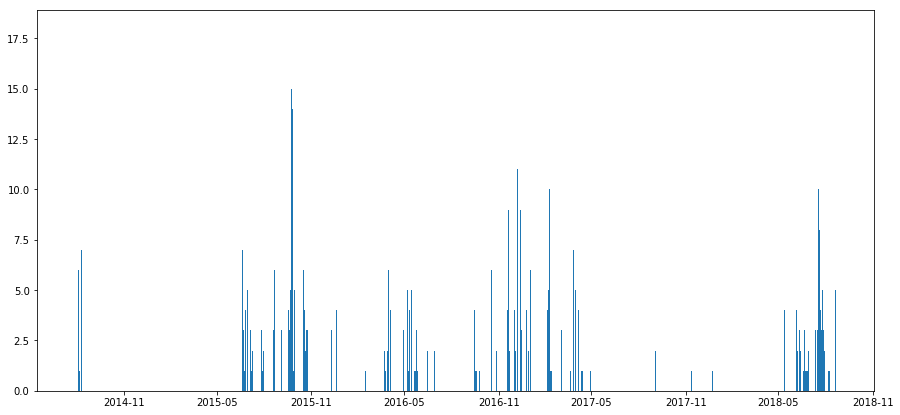

In [6]:
blitz_chess_df = df[(df['rules'] == 'chess') & (df['time_class'] == 'blitz')]
game_amount = blitz_chess_df.resample('D', on='end_time').size().values
dates = blitz_chess_df.resample('D', on='end_time').size().index

fig, ax = plt.subplots(figsize=(15,7))

ax.bar(dates, game_amount);

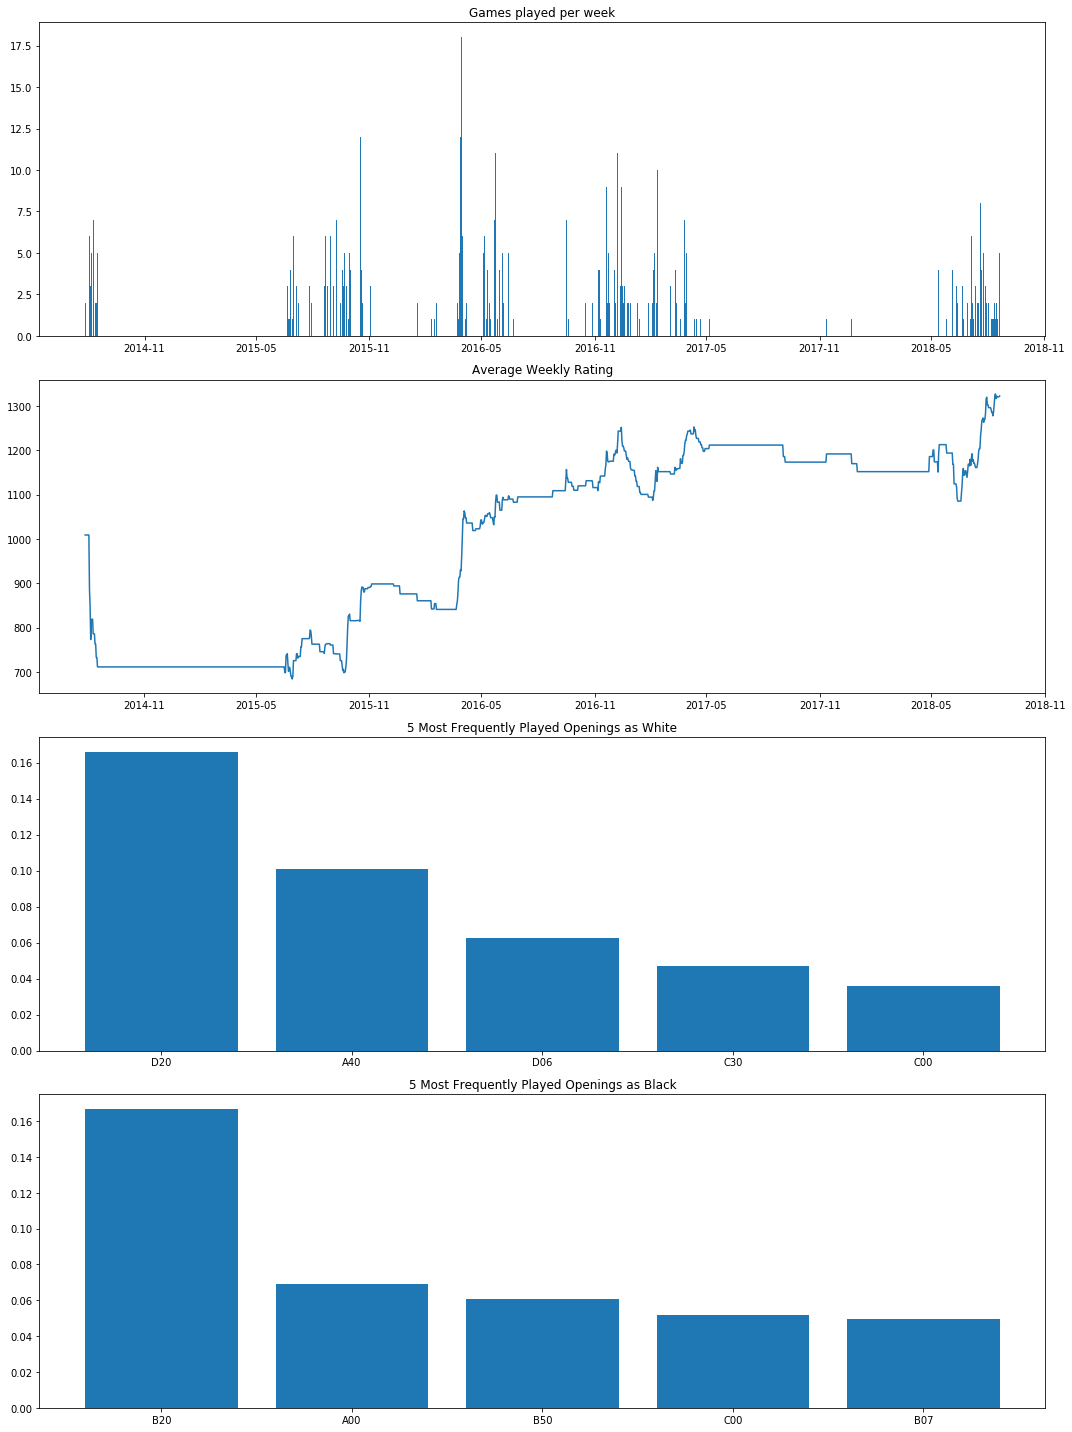

In [7]:
def chess_graphs(df, resample='W', num_openings=5):
    fig, ax = plt.subplots(4, figsize=(15, 20))

    blitz_chess_df = df[(df['rules'] == 'chess') & (df['time_class'] == 'blitz')]
    
    game_amount = blitz_chess_df.resample(resample, on='end_time').size().values
    dates = blitz_chess_df.resample(resample, on='end_time').size().index

    ax[0].bar(dates, game_amount)
    ax[0].set_title('Games played per week')

    ax[1].plot(blitz_chess_df.resample(resample, on='end_time').mean()['player_rating'].fillna(method='ffill'))
    ax[1].set_title('Average Weekly Rating')

    games_played_white = blitz_chess_df[blitz_chess_df.player_color == 'white'].eco.value_counts(normalize=True)[:num_openings].values
    openings_white = blitz_chess_df[blitz_chess_df.player_color == 'white'].eco.value_counts(normalize=True)[:num_openings].index

    x = np.arange(len(openings_white))

    ax[2].bar(x, games_played_white)
    ax[2].set_title(f'{num_openings} Most Frequently Played Openings as White')
    ax[2].set_xticks(x)
    ax[2].set_xticklabels(openings_white);

    games_played_black = blitz_chess_df[blitz_chess_df.player_color == 'black'].eco.value_counts(normalize=True)[:num_openings].values
    openings_black = blitz_chess_df[blitz_chess_df.player_color == 'black'].eco.value_counts(normalize=True)[:num_openings].index

    ax[3].bar(x, games_played_black)
    ax[3].set_title(f'{num_openings} Most Frequently Played Openings as Black')
    ax[3].set_xticks(x)
    ax[3].set_xticklabels(openings_black)

    fig.tight_layout();

chess_graphs(df, resample='D')

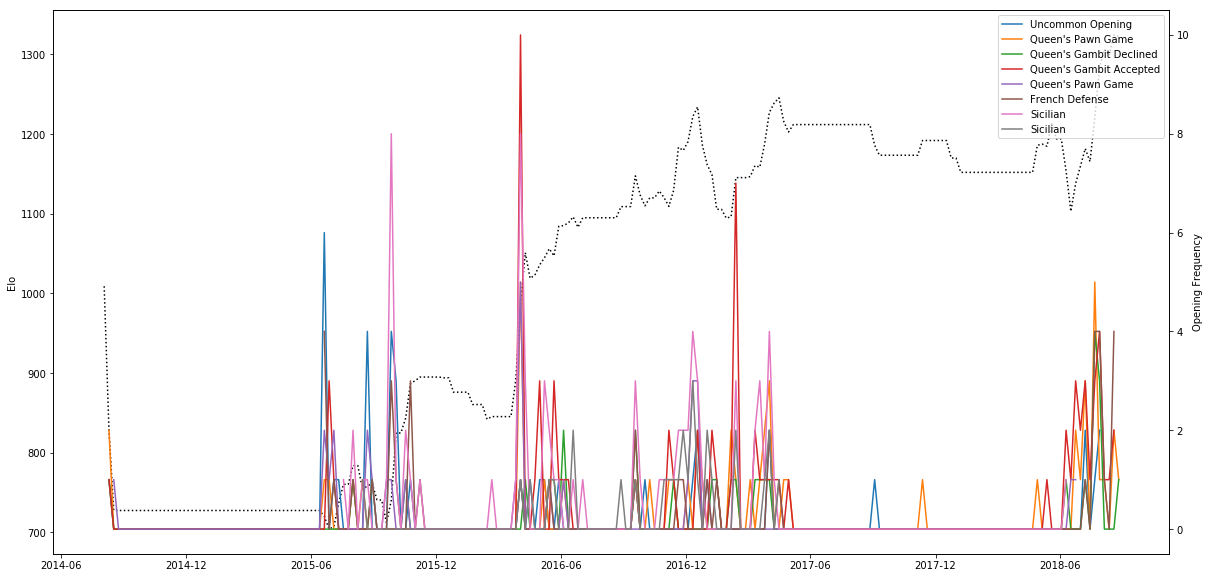

In [10]:
def openings(df, color='both', min_games=0.03, resample='W'):
    '''Return a graph of elo on the right x axis and frequency of openings played on the left axis over time (weeks)
    Params
        df: pandas dataframe
        color: Filter games by color played, white or black. Default is both.
        min_games: Filter openings displayed by a minimum percentage of total games played. Default is 3%, meaning
                   openings which were played less than 3% of the total games played are omitted'''
    
    eco_names = cs.eco_labels('../data/eco_names.json')
    blitz_chess_df = df[(df['rules'] == 'chess') & (df['time_class'] == 'blitz')]
    
    fig, ax1 = plt.subplots(figsize=(20, 10))

    ax2 = ax1.twinx()

    if color == 'both':
        color_df = blitz_chess_df
    elif (color == 'white') or (color == 'black'):
        color_df = blitz_chess_df[blitz_chess_df['player_color'] == color]

    openings = color_df['eco'].unique()

    total_games = color_df.size
    games_per_week = color_df.resample(resample, on='end_time').size()

    ax1.plot(color_df.resample(resample, on='end_time').mean()['player_rating'].fillna(method='ffill'), color='black', linestyle=':')
    ax1.set_ylabel('Elo', color='black')

    for opening in openings:
        games_with_opening = color_df[color_df['eco'] == opening].size
        percentage_of_games_with_opening = games_with_opening / total_games

        if (percentage_of_games_with_opening) > min_games:
            ax2.plot(color_df[color_df.eco == opening].resample(resample, on='end_time').size(),label=eco_names[opening])
            ax2.set_ylabel('Opening Frequency')
            ax2.legend()
            
openings(df)

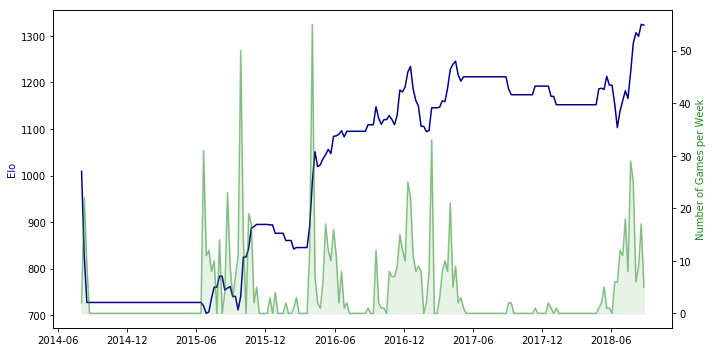

In [15]:
eco_names = cs.eco_labels('../data/eco_names.json')

fig, ax1 = plt.subplots(figsize=(10,5))

x = blitz_chess_df.resample('W', on='end_time').sum().index
y = blitz_chess_df.resample('W', on='end_time').size()

ax2 = ax1.twinx()

ax2.plot(y, 'forestgreen', alpha=.5)
ax2.fill_between(x, 0, y, alpha=.1, color='forestgreen')
ax2.set_ylabel('Number of Games per Week', color='forestgreen')

ax1.plot(blitz_chess_df.resample('W', on='end_time').mean()['player_rating'].fillna(method='ffill'), 'darkblue')
ax1.set_ylabel('Elo', color='darkblue')
         
fig.tight_layout()

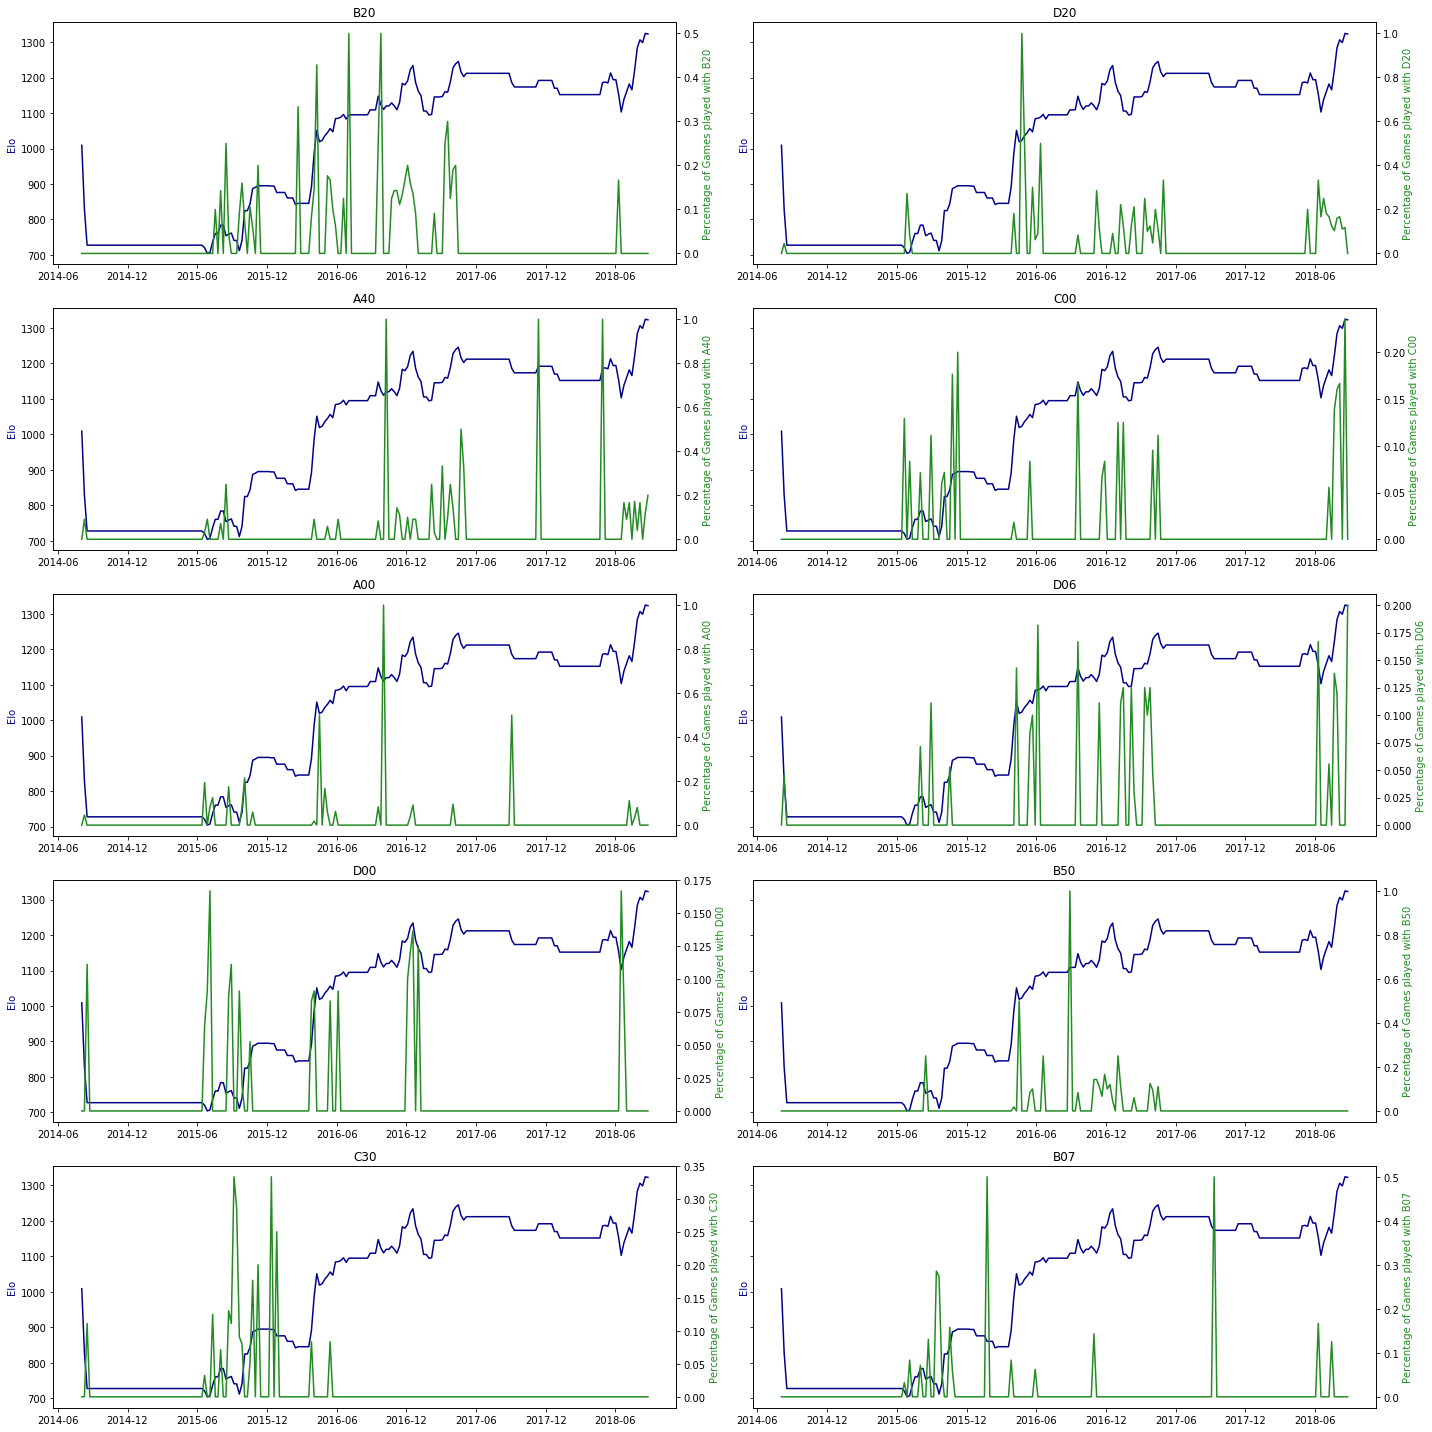

In [16]:
blitz_chess_df = df[(df['rules'] == 'chess') & (df['time_class'] == 'blitz')]

y_plot = int(len(popular_openings) / 2)

fig, ax1 = plt.subplots(y_plot, 2, figsize=(20, 4*y_plot), sharey='all')

for ax, opening in zip(ax1.flatten(), popular_openings):
    ax2 = ax.twinx()

    ax2.plot((blitz_chess_df[blitz_chess_df.eco == opening].resample('W', on='end_time').size() /
              blitz_chess_df.resample('W', on='end_time').size()).fillna(0),
             'forestgreen')
    ax2.set_ylabel(f'Percentage of Games played with {opening}', color='forestgreen')

    ax.plot(blitz_chess_df.resample('W', on='end_time').mean()['player_rating'].fillna(method='ffill'), 'darkblue')
    ax.set_ylabel('Elo', color='darkblue')
    ax.set_title(opening)
    
    fig.tight_layout()

In [ ]:
file = open('/Users/bmcgarry/galvanize/ChessCapstone/ChessStyle/data/eco_codes.txt', 'r')
eco_names = {}
for idx, line in enumerate(file):
    if idx % 2 == 0:
        eco_names[line[:3]] = line[4:-1]
    else:
        eco_names[line]